### Filipino Fake News Detection

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

2024-03-31 04:03:32.894360: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-31 04:03:32.894392: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
tf.random.set_seed(42)

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv("full.csv")
data.head()

,label,article
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


In [6]:
shuffle_data = data.sample(frac=1, random_state=42)

Split data into train-test set

In [7]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
                                                shuffle_data['article'].to_numpy(), 
                                                shuffle_data['label'].to_numpy(),
                                                test_size=0.2, 
                                                stratify=data['label'], 
                                                random_state=42
                                            )

In [6]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(2564, 2564, 642, 642)

In [8]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['Para sa mga nag aabang ng Social Security Contribution Table as taong 2019 narito ang maging guide natin. Naka-iskedyul ng mga kontribusyon para sa self-employed, Mga Overseas Filipino Worker at boluntaryong mga miyembro, tingnan ang listahan sa ibaba. Scheduled of contributions for self-employed, Overseas Filipino Workers and voluntary members, see the list below. Note that the minimum salary credit for OFW member is P5,000.',
        'Masaya niyang ibinalita na annulled na o napawalang-bisa na ang kasal niya kay Meryll Soriano. Naging bunga ng pagsasama nila ng aktres ang kaisa-isa nilang anak na si Elijah. "After six to seven years , I\'m legally annulled," pahayag ni Bernard. Wala na raw sagabal sa kanila ni Jerika kapag naisip na nilang magpakasal. "We are on the right path. Legally, I can ask her,\' sey ng aktor. Handa na rin daw siyang pakasalan si Jerika dahil ito ang ipinangako niya sa sarili, ang ihatid sa altar ang anak ni Manila Mayor Joseph "Erap" Estrada. "I don\

In [9]:
max_vocab_length = 10000
max_length = max([len(x.split(" ")) for x in data['article']])

In [10]:
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

2024-03-31 04:05:06.790567: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-03-31 04:05:06.790641: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2024-03-31 04:05:06.790687: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ideapadv110): /proc/driver/nvidia/version does not exist
2024-03-31 04:05:06.794216: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [12]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

In [13]:
# Get a random sentence from training set
import random
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Ito ang inihayag ni Department of Justice (DoJ) Secretary Leila de Lima matapos makausap ni Pangulong Aquino si Malaysian Prime Minister Najib Razak hinggil sa kaso ni Amalilio sa ginanap na 25th ASEAN-Republic of Korea commemorative summit sa Seoul.      

Embedded version:


<tf.Tensor: shape=(1, 1076, 128), dtype=float32, numpy=
array([[[ 0.04978979, -0.0019431 , -0.00039934, ..., -0.01621551,
          0.03926425,  0.02467387],
        [-0.04364428,  0.02437404, -0.03696011, ..., -0.04763393,
          0.02931459,  0.0068561 ],
        [ 0.03233189,  0.02018218, -0.03004571, ..., -0.01061187,
          0.01735066,  0.01628271],
        ...,
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097],
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097],
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097]]], dtype=float32)>

In [22]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs, name="Bidirectional_model")


In [23]:
# Compile
model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [24]:
# Get a summary of our bidirectional model
model.summary()

Model: "Bidirectional_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 1076)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1076, 128)         1280000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
81/81 [==============================] - 117s 1s/step - loss: 0.4231 - accuracy: 0.8186 - val_loss: 0.3781 - val_accuracy: 0.8364
Epoch 2/5
81/81 [==============================] - 117s 1s/step - loss: 0.1552 - accuracy: 0.9571 - val_loss: 0.1402 - val_accuracy: 0.9579
Epoch 3/5
81/81 [==============================] - 123s 2s/step - loss: 0.0574 - accuracy: 0.9856 - val_loss: 0.1183 - val_accuracy: 0.9642
Epoch 4/5
81/81 [==============================] - 114s 1s/step - loss: 0.0286 - accuracy: 0.9930 - val_loss: 0.1177 - val_accuracy: 0.9657
Epoch 5/5
81/81 [==============================] - 119s 1s/step - loss: 0.0057 - accuracy: 0.9992 - val_loss: 0.1201 - val_accuracy: 0.9688


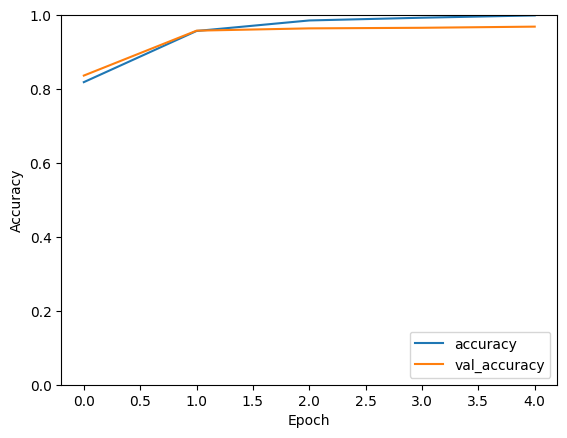

In [28]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

plot_history(history)